# Magma Dike Flux Model
#### Lister (1990)

In [1]:
# preamble

import os
import sys
import matplotlib.pyplot as plt
import pdb
import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import erfc, erf
import pandas as pd
from matplotlib import ticker
import scipy as sp
from scipy.integrate import cumulative_trapezoid, trapezoid, odeint, solve_bvp, solve_ivp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colormaps
import matplotlib.ticker as mtick
from matplotlib.ticker import LogLocator, FuncFormatter, NullFormatter, FixedLocator, StrMethodFormatter, LogFormatter, LogFormatterSciNotation, LogFormatterExponent, LogFormatterMathtext, MaxNLocator, MultipleLocator
from matplotlib.lines import lineStyles
import cmocean
import cmocean.cm as cmo
from matplotlib.colors import LogNorm
from IPython.display import clear_output
import matplotlib.patheffects as pe
from matplotlib.collections import LineCollection
from labellines import labelLines
def sci_fmt(x):
    if x == 0 or not np.isfinite(x):
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / (10**exp)
    # round mantissa to integer as you requested
    return rf"{mant:.0f}$×10^{{exp}}$"

# constants

beta = 4e-10 # Pa-1, compressibility at ~273.15 K
rhow = 2700 # kg m-3
rhoi = 3000 # kg m-3
delta_rho = 300 # kg m-3
Cp = 1.604e3 # J kg-1 K, water
kappa = 0.3e-6 # thermal diffusivity (m2/s)
k = 2 # thermal conductivity (W/m K)
λ = 0.71 # thermodynamic parameter of ice (adimensional)
g = 9.81 # m/s2
nu = 0.25 # Poisson's ratio
E = 45e9 # Pa, Young's modulus
G = 30e9 # Pa, shear modulus from Berne et al., 2023
m = G / (1 - nu)
eta_m = 0.1 # Pa s, viscosity of water
# L = 334e3 # J/kg, latent heat of fusion
# c = 1 # J kg-1 K-1, specific heat capacity of ice at ~100 K

# tensile strength
S = 20e6 # Pa, tensile strength of ice
Kc = 1.5e6 # Pa m1/2, fracture toughness of ice


In [3]:
max_depth = 100e3
z = np.logspace(np.log10(3000), np.log10(max_depth), 100)  # m, log-spaced
w = np.linspace(0.01, 5, 100) 
W, Z = np.meshgrid(w, z)
eta = 100 # Pa s, viscosity of laminar magma
m = 20e9 # Pa, effective shear modulus of rock magma system

# Lister and Kerr (1991)
q1 = ((W)/ (0.904))**10
q2 = (((-delta_rho) * g)**2 * Z * m) / (eta**3)
Q_grid = (q1 * q2)**(1/3)
logQ = np.log10(Q_grid)
Q_m3 = Q_grid
Q_km3 = Q_m3/1e9


(3, 100)

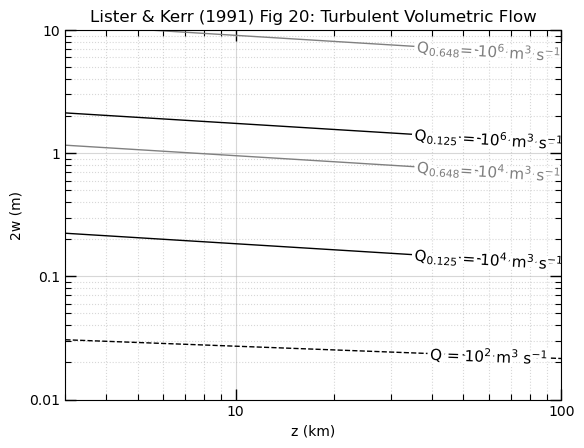

In [4]:
# Fig 20 from Lister & Kerr (1991) 

z = np.logspace(np.log10(3e3), np.log10(100e3), 100)  # meters, log-spaced
q = np.logspace(2, 6, 3)
Q, Z = np.meshgrid(q, z)
eta = 0.1 # Pa s, viscosity of magma
Qlog = np.log10(Q)
rhom = 2600 
# μ = 20e9
# v = 0.23
# m = μ / (1 - v)
m = 20e9

fig, ax = plt.subplots()
for a in [2, 4, 6]:
    if a >= 4:
        Q = 10**a
        # x = 0 # at the center of the breadth
        # xi = 0.66 * x * ((g * delta_rho)**16 / (Q**7 * eta * rhom**3 * (m * Z)**12))**(1/43) # ~0
        # w_big = (1 - xi**2)**(3/2)
        w_big = 1 # at x=0
        # Eq 58       
        w_648 = 0.648 * ( (Q**21 * eta**3 * rhom**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
        w = 0.125 * ( (Q**21 * eta**3 * rhom**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
        e = np.log10(Q)
        ls = 'solid'
        ax.plot(z/1e3, 2*w, color='black', linewidth=1, linestyle=ls,
                label=rf'Q$_{{{0.125}}}$ = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
        ax.plot(z/1e3, 2*w_648, color='gray', linewidth=1, linestyle='solid', label=rf'Q$_{{{0.648}}}$= 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$' )
    else:
        # w = (4 * Kc**2 * eta * Q / (np.pi * m**2 * delta_rho * g))**(1/5)
        Q = 10**a
        # x = 0 # at the center of the breadth
        # xi = 0.381 * x * ((g * delta_rho)**4 / (Q * eta * m**3 * z**3))**(1/10) # ~0
        # w_big = (1 - xi**2)**(3/2)
        w_big = 1 # at x=0
        # Eq 36
        w = 0.904 * ( (Q**3 * eta**3) / (m * (delta_rho * g)**2 * z) )**(1/10) * w_big
        e = np.log10(Q) 
        ls = 'dashed'
        ax.plot(z/1e3, 2*w, color='black', linewidth=1, linestyle=ls,
            label=rf'Q = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    

labelLines(ax.get_lines(), xvals=[60, 60, 60, 60, 60], align=True, fontsize=11)

ax.set_ylabel('2w (m)')
ax.set_xlabel('z (km)')
ax.loglog()
ax.set_xlabel('z (km)')
ax.set_ylabel('2w (m)')
ax.set_axisbelow(True) # this puts gridlines behind contours
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1, direction='in', top=True, right=True)
ax.tick_params(which='minor', length=4, width=0.8, direction='in', top=True, right=True)
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.5, linestyle=':')
ax.set_title('Lister & Kerr (1991) Fig 20: Turbulent Volumetric Flow')
ax.set_ylim(0.01, 10)
ax.set_xlim(3, 100)

## $ q=-\frac{15.4}{(\mu\rho_w^3|\nabla p|^3)^{\frac{1}{7}}}w^{\frac{12}{7}}\nabla p $

## $ -\frac{q \nabla p(\mu\rho_w^3|\nabla p|^3)^{\frac{1}{7}}}{15.4}=w^{\frac{12}{7}} $

## $ w =(-\frac{q g\Delta\rho(\mu\rho_w^3|g\Delta\rho|^3)^{\frac{1}{7}}}{15.4})^{\frac{7}{12}} $


In [5]:
# gamma function
from scipy.special import gamma
a_Lister = 12/7
G_up = gamma(3*a_Lister+2)
G_low = gamma(1/2*(3*a_Lister + 2))**2
print(f'G_up = {G_up:.4f}, \nG_low = {G_low:.4f}')
bN = 1/2 * (6*(3*a_Lister+1)/a_Lister)**(a_Lister/(3*a_Lister + 1)) * (G_up / G_low)**(1/(3*a_Lister + 1))
print(f'bN = {bN:.4f}')
A = 15.4 * eta**(-1/7) * (rhom * delta_rho * g)**(-3/7)
print(f'A = {A:.4e}')

G_up = 942.3223, 
G_low = 12.9515
bN = 2.3654
A = 2.3999e-02


(3, 100)

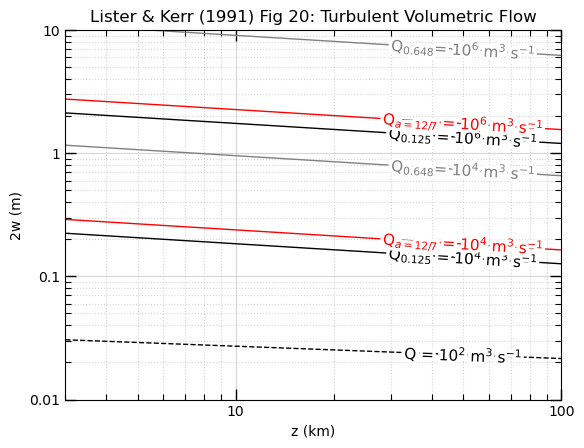

In [6]:
z = np.logspace(np.log10(3e3), np.log10(100e3), 100)  # meters, log-spaced
q = np.logspace(2, 6, 3)
Q, Z = np.meshgrid(q, z)
eta = 0.1 # Pa s, viscosity of magma
Qlog = np.log10(Q)
rhom = 2600 
# μ = 20e9
# v = 0.23
# m = μ / (1 - v)
m = 20e9

fig, ax = plt.subplots()
for a in [2, 4, 6]:
    if a >= 4:
        Q = 10**a
        # x = 0 # at the center of the breadth
        # xi = 0.66 * x * ((g * delta_rho)**16 / (Q**7 * eta * rhom**3 * (m * Z)**12))**(1/43) # ~0
        # w_big = (1 - xi**2)**(3/2)
        w_big = 1 # at x=0
        # Eq 58       
        w_648 = 0.648 * ( (Q**21 * eta**3 * rhom**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
        w = 0.125 * ( (Q**21 * eta**3 * rhom**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
        wLister = a_Lister * bN**3 / (6 * (3*a_Lister+1)) * (Q**3 / (A**3 * (g*delta_rho)**2 * m * z))**(1/(3*a_Lister + 1))
        e = np.log10(Q)
        ls = 'solid'
        ax.plot(z/1e3, 2*w, color='black', linewidth=1, linestyle=ls,
                label=rf'Q$_{{{0.125}}}$ = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
        ax.plot(z/1e3, 2*wLister, color='red', linewidth=1, linestyle=ls,
                label=rf'Q$_{{a=12/7}}$ = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
        ax.plot(z/1e3, 2*w_648, color='gray', linewidth=1, linestyle='solid', label=rf'Q$_{{{0.648}}}$= 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$' )
    else:
        # w = (4 * Kc**2 * eta * Q / (np.pi * m**2 * delta_rho * g))**(1/5)
        Q = 10**a
        # x = 0 # at the center of the breadth
        # xi = 0.381 * x * ((g * delta_rho)**4 / (Q * eta * m**3 * z**3))**(1/10) # ~0
        # w_big = (1 - xi**2)**(3/2)
        w_big = 1 # at x=0
        # Eq 36
        w = 0.904 * ( (Q**3 * eta**3) / (m * (delta_rho * g)**2 * z) )**(1/10) * w_big
        e = np.log10(Q) 
        ls = 'dashed'
        ax.plot(z/1e3, 2*w, color='black', linewidth=1, linestyle=ls,
            label=rf'Q = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    

labelLines(ax.get_lines(), xvals=[50, 50, 50, 50, 50, 50, 50], align=True, fontsize=11)

ax.set_ylabel('2w (m)')
ax.set_xlabel('z (km)')
ax.loglog()
ax.set_xlabel('z (km)')
ax.set_ylabel('2w (m)')
ax.set_axisbelow(True) # this puts gridlines behind contours
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1, direction='in', top=True, right=True)
ax.tick_params(which='minor', length=4, width=0.8, direction='in', top=True, right=True)
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.5, linestyle=':')
ax.set_title('Lister & Kerr (1991) Fig 20: Turbulent Volumetric Flow')
ax.set_ylim(0.01, 10)
ax.set_xlim(3, 100)